# Post-training integer quantization with 16 bit activation

#### 16 bit on activation has been suggested to cut down the model size while mainitaining high accuracy as much as possible.

#### For comparison, we would show the storage size and accuracy of a model
#### with no optimization (no additional attributes added to converter() class)
#### and the optimized with 16-bit activation one.

## Setup

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow r2.3:

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
assert float(tf.__version__[:3]) >= 2.3

In [2]:
# get Fasion Mnist dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

In [3]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(15,activation='relu'),
  tf.keras.layers.Dense(10)
])

In [4]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 22s 10ms/step - loss: 0.4611 - accuracy: 0.8368 - val_loss: 0.3839 - val_accuracy: 0.8625
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3069 - accuracy: 0.8871 - val_loss: 0.3466 - val_accuracy: 0.8731
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2551 - accuracy: 0.9064 - val_loss: 0.3358 - val_accuracy: 0.8868
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2204 - accuracy: 0.9189 - val_loss: 0.3538 - val_accuracy: 0.8796
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1952 - accuracy: 0.9269 - val_loss: 0.3507 - val_accuracy: 0.8846


In [5]:
import tempfile

_, pretrained = tempfile.mkstemp('.tf')

model.save_weights(pretrained)

In [6]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15,activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  return model


In [7]:
def get_model():
  model = build_model()
  model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  model.load_weights(pretrained)
  return model

# test if it works
_m = get_model()
_ = _m.evaluate(test_images,test_labels)

313/313 [==============================] - 2s 4ms/step - loss: 0.3507 - accuracy: 0.8846


## Convert to a TensorFlow Lite model

### Convert model to a tflite model with no optimization

#### As a comparision to our optimized model in the following cells

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5zw9ozmd/assets


### Convert using weight-8-activation-16 quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [9]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# the 2nd term ensures that if there are unsupported
# ops that can be convert to intOps, leave them as floatOps
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpb4lpnlnm/assets


INFO:tensorflow:Assets written to: /tmp/tmpb4lpnlnm/assets


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [10]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


### Save the models as files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [11]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/fmnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"fmnist_model.tflite"
unquantized_size = tflite_model_file.write_bytes(tflite_model)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"fmnist_model_quant.tflite"
quantized_size = tflite_model_quant_file.write_bytes(tflite_model_quant)

print("float model size: %5d\nquantized model size: %5d" % (unquantized_size,quantized_size))

float model size: 282940
quantized model size: 76688


Check the model size using shell command

In [12]:
!ls -lh {tflite_models_dir}

total 576K
-rw-r--r-- 1 root root 143K Apr  1 14:44 fmnist_model_quant_float.tflite
-rw-r--r-- 1 root root  74K Apr  1 14:44 fmnist_model_quant_intonly.tflite
-rw-r--r-- 1 root root  75K Apr  1 14:47 fmnist_model_quant.tflite
-rw-r--r-- 1 root root 277K Apr  1 14:47 fmnist_model.tflite


## Run the TensorFlow Lite models

Now we'll run inferences via TensorFlow Lite Interpreter to compare the model accuracies.

Define a function that runs inference with a given model and images, and then returns the predictions:


In [13]:
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


### Test the models on one image


Remember, `tflite_model_file` is the original TensorFlow Lite model with floating-point data,

while `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

In [14]:
import matplotlib.pylab as plt

def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

In [15]:
# set the image to check
test_image_index = 50

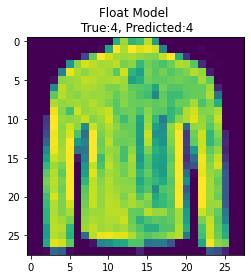

In [16]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:

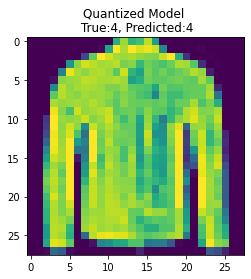

In [17]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluate the models on all images

Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [18]:
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [19]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 88.4600% (Number of test samples=10000)


Evaluate the quantized model:

In [20]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 88.4200% (Number of test samples=10000)


### As the result shown, the quantized model shown little difference in accuracy
### and 75% model size reduction compare to the original model.

### Integer only

In [21]:
model = get_model()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_intonly = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_intonly)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

# storage size
tflite_model_quant_intonly_file = tflite_models_dir/"fmnist_model_quant_intonly.tflite"
quantized_intonly_size = tflite_model_quant_intonly_file.write_bytes(tflite_model_quant_intonly)

print("quantized int only model size: %5d" % (quantized_intonly_size))

evaluate_model(tflite_model_quant_intonly_file, model_type='Quantized_int_only')

INFO:tensorflow:Assets written to: /tmp/tmp7qygmhay/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qygmhay/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>
quantized int only model size: 75768
Quantized_int_only model accuracy is 88.5100% (Number of test samples=10000)


### Float16


In [22]:
model = get_model()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model_quant_float = converter.convert()


interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

# storage size
tflite_model_quant_float_file = tflite_models_dir/"fmnist_model_quant_float.tflite"
quantized_float_size = tflite_model_quant_float_file.write_bytes(tflite_model_quant_float)

print("quantized int only model size: %5d" % (quantized_float_size))

evaluate_model(tflite_model_quant_float_file, model_type='Quantized_float_only')


INFO:tensorflow:Assets written to: /tmp/tmpor8e0_ad/assets


INFO:tensorflow:Assets written to: /tmp/tmpor8e0_ad/assets


input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>
quantized int only model size: 145664
Quantized_float_only model accuracy is 88.4600% (Number of test samples=10000)
